# Liver Model Construction: Notebook

Trying to get switch between glycolysis and gluconeogenesis without compartments. Copy of 0.0.1-glycolysis_gluco_w_out_comp_split 

started on 1 june 2022

updates:
- tryign to make a function to haave objective fucntion based on glucose conc

In [1]:
import os
import re
import warnings
# from cobra.io import 
import cobra
from cobra.io.json import *
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite, DictList
import cobra.test
from os.path import join
from mass.util import qcqa,qcqa_model
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)


import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz


MASSpy version: 0.1.6


In [2]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")

### Getting reactions and metabolite data from RECON 3D

In [3]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"gly_gluco_no_compts_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')

# making dataframe of reactions
# csv_rxn = os.path.join(data_dir,"gly_gluco_reaction_df.csv")
# rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
# reaction_info = rxn_csv_df.to_dict(orient='index')

### Loading cobra model

In [4]:
# Initiate empty model
trial= cobra.Model()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-07-04


In [5]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], 
                        #    compartment=info['compartment']
                           )
    trial.add_metabolites(met)

In [6]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"gly_gluco_no_compt_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [7]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [8]:
#adding NADHM 
nadhm = {'nadh': -1, 'h': 1, 'nad': 1}
rxn = cobra.Reaction('NADHM')
trial.add_reaction(rxn)
rxn.add_metabolites(nadhm)




# peptm = {'pep': -1, 'pi': -1, 'pi': 1, 'pep':1}
# rxn2 = cobra.Reaction('PEPtm')
# trial.add_reaction(rxn2)
# rxn2.add_metabolites(peptm)



g6pase = {'g6p': -1, 'h2o': -1, 'pi': 1, 'glc__D':1}
rxn3 = cobra.Reaction('G6PP')
trial.add_reaction(rxn3)
rxn3.add_metabolites(g6pase)
trial.reactions.G6PP.lower_bound=0



In [9]:
trial.metabolites.h.charge= 1
# trial.metabolites.h.charge= 1
# trial.metabolites.h_e.charge= 1
trial.metabolites.pi.charge= -2
# trial.metabolites.pi_m.charge= -2

In [10]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
FBP {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PEPCKm {}
PYK {}
PCm {}
LDH_L {}
ADK1 {}
ATPM {}
NADHM {'charge': 2}
G6PP {}


In [11]:
# print(trial.reactions.FBA.check_mass_balance())

In [16]:
# View all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json"),highlight_missing=True)

escher_builder

Builder(highlight_missing=True)

In [15]:
for met in ['glc__D', 
'h2o', 'h', 'pi','lac__L',    'pyr',
# 'o2',
'co2',
'hco3', 'gtp',
'amp',     'gdp',    'adp',
    # 'atp',

     ]:
    rxn = cobra.Reaction('EX_%s' % met)
    name = rxn.id
    if name not in trial.reactions:
        print(rxn.id)
        trial.add_reaction(rxn)
        rxn.add_metabolites({met: -1})
        if met == 'glc__D':
            rxn.lower_bound = -1 # by convention negative exchange flux = uptake
            rxn.upper_bound = 10
        elif met == 'amp':
            rxn.upper_bound = 1
        # elif met == 'atp':
        #     rxn.upper_bound = 0

        else:
            rxn.lower_bound = -1000

In [35]:
trial.objective = "EX_glc__D"
flux_solution = trial.optimize()
flux_solution.fluxes

HEX1         0.00
PGI         -0.25
FBP          0.25
PFK          0.00
FBA         -0.25
TPI         -0.25
GAPD        -0.50
PGK          0.50
PGM          0.50
ENO         -0.50
PEPCKm       0.50
PYK          0.00
PCm          0.50
LDH_L        0.50
ADK1        -1.00
ATPM         0.00
NADHM        0.00
G6PP         0.25
EX_glc__D    0.25
EX_h2o      -1.00
EX_h         0.50
EX_pi        1.50
EX_lac__L   -0.50
EX_pyr       0.00
EX_co2       0.50
EX_hco3     -0.50
EX_gtp      -0.50
EX_amp       1.00
EX_gdp       0.50
EX_adp      -1.00
Name: fluxes, dtype: float64

In [22]:
# from cobra.flux_analysis.moma import moma

In [23]:
# moma?
# print(trial.reactions.FBA.check_mass_balance())

In [24]:
import escher
from escher import Builder

In [25]:
fluxes = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

In [26]:
# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json"),
    reaction_data=fluxes)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 0.0, 'PGI': -0.25, 'FBP': 0.25, 'PFK': 0.0, 'FBA': -0.25, 'TPI': -0.25, 'GAPD':…

In [27]:
# np.linspace?
# for 
switch = pd.DataFrame(columns=["Gluc_conc", "Objective_val"])
range = np.linspace(2,14,num=240)
list_objs=[]
for i in range:
    
    if i >7.5:
        trial.objective = 'ATPM'
        flux_solution = trial.optimize()
        obj_val = flux_solution.objective_value
    else:
        trial.objective = "EX_glc__D"
        flux_solution = trial.optimize()
        obj_val = flux_solution.objective_value
    list_objs.append(obj_val)
   
switch["Gluc_conc"] = range
switch["Objective_val"] = list_objs
switch= switch.set_index("Gluc_conc")

        

In [28]:
from matplotlib import pyplot as plt

<AxesSubplot:>

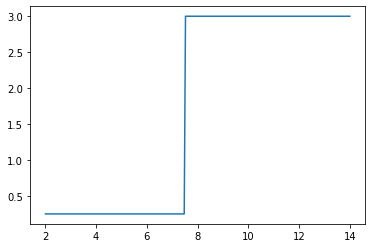

In [29]:
fig, ax = plt.subplots(1,1)
plt.plot(switch["Objective_val"])
ax

## Solution Space (sampling)

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp3t5h1irs.lp
Reading time = 0.01 seconds
: 25 rows, 60 columns, 170 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpeo2vn3b2.lp
Reading time = 0.01 seconds
: 25 rows, 60 columns, 170 nonzeros


Text(0.5, 0, 'FBP flux')

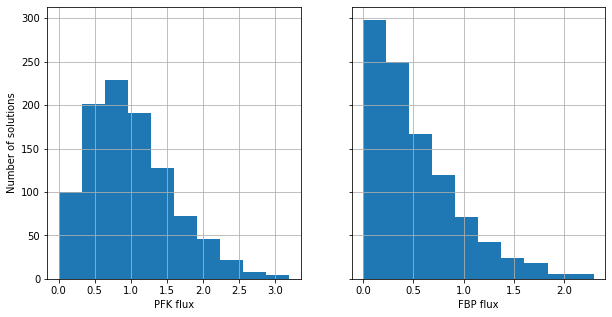

In [30]:
combined =trial.copy()
combined.objective= "ATPM"
df = cobra.sampling.sample(combined, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['PFK'].hist(ax=ax)
ax.set_xlabel('PFK flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['FBP'].hist(ax=ax)
ax.set_xlabel('FBP flux')

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpqa64h0qv.lp
Reading time = 0.01 seconds
: 25 rows, 60 columns, 170 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmprbgprmgm.lp
Reading time = 0.00 seconds
: 25 rows, 60 columns, 170 nonzeros


Text(0.5, 0, 'FBP flux')

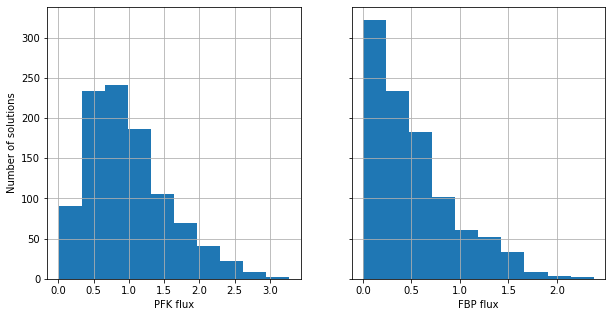

In [31]:
combined =trial.copy()
combined.objective= "EX_glc__D"
df = cobra.sampling.sample(combined, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['PFK'].hist(ax=ax)
ax.set_xlabel('PFK flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['FBP'].hist(ax=ax)
ax.set_xlabel('FBP flux')

## FVA analysis

In [32]:
def plot_fva(atpm_values, max_pfk_values, max_fbp_values, min_pfk_values, min_fbp_values):
    """
    Parameters
    ----------
    atpm_values : list
        list of ATPM flux values from 0 to max
        
    max_g6pdh_values : list
        list of maximum G6PDH2r flux values at the ATPM fluxes in atpm_values
    max_pgi_values : list
        list of maximum PGI flux values at the ATPM fluxes in atpm_values

    min_g6pdh_values : list 
        list of minimum G6PDH2r flux values at the ATPM fluxes in atpm_values

    min_pgi_values : list
        list of minimum PGI flux values at the ATPM fluxes in atpm_values

    """
    plt.fill_between(atpm_values, max_pfk_values, min_pfk_values, 
                     label='Glycolysis', alpha=.7)
    plt.fill_between(atpm_values, max_fbp_values, min_fbp_values, 
                     label='Gluconeogenesis', alpha=.7)
    plt.legend()
    plt.xlabel('ATPM flux')
    plt.ylabel('Range of possible fluxes')

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmprdxzocdi.lp
Reading time = 0.00 seconds
: 25 rows, 60 columns, 170 nonzeros


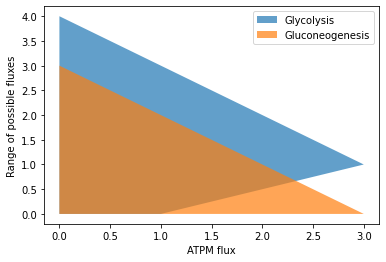

In [33]:
combined = trial.copy()
rxn = 'ATPM'
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpn3q4q205.lp
Reading time = 0.00 seconds
: 25 rows, 60 columns, 170 nonzeros
0.25


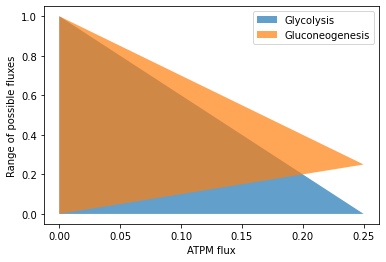

In [34]:
combined = trial.copy()
rxn = "EX_glc__D"
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp2uix_2lf.lp
Reading time = 0.00 seconds
: 25 rows, 60 columns, 170 nonzeros
3.0


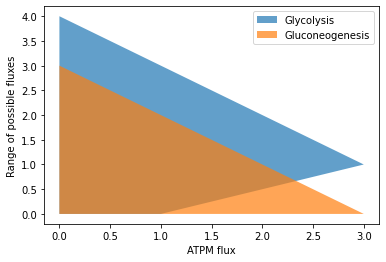

In [39]:
combined = trial.copy()
rxn = "ATPM"
var_rxn = 'HEX1'
var_rxn_2 = 'G6PP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

In [30]:
trial.problem.Constraint

optlang.gurobi_interface.Constraint

In [31]:
same_flux = trial.problem.Constraint(
    trial.reactions.PFK.flux_expression - trial.reactions.FBP.flux_expression,
    lb=0,
    ub=1)
trial.add_cons_vars(same_flux)

In [32]:
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
HEX1,1.0,0.0
PGI,1.0,0.0
FBP,0.0,-2.0
PFK,1.0,0.0
FBA,1.0,0.0
...,...,...
EX_hco3,0.0,0.0
EX_gtp,0.0,-0.0
EX_amp,1.0,2.0
EX_gdp,0.0,0.0


In [33]:
solution = trial.optimize()
print(solution.fluxes['FBP'], solution.fluxes['PFK'],
      solution.objective_value)



0.0 1.0 3.0


In [34]:
from cobra.flux_analysis import flux_variability_analysis

In [35]:
trial.optimize()
trial.summary(fva=0.95)

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
adp,EX_adp,1,[0.85; 1],10,62.50%
glc__D,EX_glc__D,1,[0.925; 1],6,37.50%
h2o,EX_h2o,1,[0.85; 1],0,0.00%
Metabolite,Reaction,Flux,Range,C-Number,C-Flux
amp,EX_amp,-1,[-1; -0.85],10,62.50%
co2,EX_co2,0,[-998.1; 0],1,0.00%
gdp,EX_gdp,0,[-998.1; 0],10,0.00%
gtp,EX_gtp,0,[0; 998.1],10,0.00%
h,EX_h,-3,[-1000; -2.85],0,0.00%
hco3,EX_hco3,0,[0; 998.1],1,0.00%


In [36]:
flux_variability_analysis(trial, trial.reactions)

,minimum,maximum
HEX1,1.0,1.0
PGI,1.0,1.0
FBP,0.0,0.0
PFK,1.0,1.0
FBA,1.0,1.0
TPI,1.0,1.0
GAPD,2.0,2.0
PGK,-2.0,-2.0
PGM,-2.0,-2.0
ENO,2.0,2.0


In [37]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 1.0, 'PGI': 1.0, 'FBP': 0.0, 'PFK': 1.0, 'FBA': 1.0, 'TPI': 1.0, 'GAPD': 2.0, '…

In [38]:
trial.objective = 'ATPM'
fba_solution = trial.optimize()
pfba_solution = cobra.flux_analysis.pfba(trial)
pfba_solution


,fluxes,reduced_costs
HEX1,1.0,-2.0
PGI,1.0,-2.0
FBP,0.0,24.0
PFK,1.0,-2.0
FBA,1.0,-2.0
...,...,...
EX_hco3,0.0,2.0
EX_gtp,0.0,2.0
EX_amp,1.0,-12.0
EX_gdp,0.0,2.0


In [39]:
geometric_fba_sol = cobra.flux_analysis.geometric_fba(trial)
geometric_fba_sol

,fluxes,reduced_costs
HEX1,1.0,0.0
PGI,1.0,0.0
FBP,0.0,0.0
PFK,1.0,0.0
FBA,1.0,0.0
...,...,...
EX_hco3,0.0,0.0
EX_gtp,0.0,0.0
EX_amp,1.0,0.0
EX_gdp,0.0,0.0


In [40]:

from cobra.sampling import sample

# model = load_model("textbook")
s = sample(trial, 100)
# s.head()
s


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpocztcjfs.lp
Reading time = 0.00 seconds
: 26 rows, 61 columns, 175 nonzeros


,HEX1,PGI,FBP,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,...,EX_h,EX_pi,EX_lac__L,EX_pyr,EX_co2,EX_hco3,EX_gtp,EX_amp,EX_gdp,EX_adp
0,2.018614,0.799294,0.140017,0.939311,0.799294,0.799294,1.598589,-1.598589,-1.598589,1.598589,...,350.451086,770.928321,-172.764131,174.362720,770.801264,-770.801264,-770.801264,0.127057,770.801264,-0.127057
1,0.645976,0.602786,0.390965,0.993751,0.602786,0.602786,1.205572,-1.205572,-1.205572,1.205572,...,745.690145,476.924450,-370.798775,372.004347,476.448572,-476.448572,-476.448572,0.475879,476.448572,-0.475879
2,3.265300,0.959016,0.216957,1.175973,0.959016,0.959016,1.918032,-1.918032,-1.918032,1.918032,...,344.148326,350.405403,-168.729866,170.647898,349.470906,-349.470906,-349.470906,0.934498,349.470906,-0.934498
3,2.817184,0.888508,0.160744,1.049251,0.888508,0.888508,1.777015,-1.777015,-1.777015,1.777015,...,705.472788,515.969217,-349.626456,351.403471,515.080387,-515.080387,-515.080387,0.888830,515.080387,-0.888830
4,1.699406,0.776811,0.311675,1.088486,0.776811,0.776811,1.553623,-1.553623,-1.553623,1.553623,...,691.577286,39.018721,-343.092728,344.646351,38.287760,-38.287760,-38.287760,0.730961,38.287760,-0.730961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.783077,0.988375,0.131441,1.119816,0.988375,0.988375,1.976751,-1.976751,-1.976751,1.976751,...,171.034757,627.885747,-82.445284,84.422034,627.671809,-627.671809,-627.671809,0.213938,627.671809,-0.213938
96,0.479226,0.191447,0.613913,0.805360,0.191447,0.191447,0.382895,-0.382895,-0.382895,0.382895,...,579.452396,148.264781,-288.820056,289.202951,147.601182,-147.601182,-147.601182,0.663600,147.601182,-0.663600
97,1.129368,0.404478,0.495244,0.899722,0.404478,0.404478,0.808956,-0.808956,-0.808956,0.808956,...,199.236466,562.826340,-98.150760,98.959717,562.318263,-562.318263,-562.318263,0.508077,562.318263,-0.508077
98,0.651453,0.076424,0.319169,0.395593,0.076424,0.076424,0.152848,-0.152848,-0.152848,0.152848,...,856.400933,807.185055,-427.534014,427.686862,806.310693,-806.310693,-806.310693,0.874362,806.310693,-0.874362


In [41]:

from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob

In [42]:
gly_gluco_json = os.path.join(model_dir,"glycolysis_gluconeogenesis.json")
json.save_json_model(model=trial, filename=gly_gluco_json)

In [43]:
# import cplex 
# import gurobipy 

In [44]:
for model_file in glob(gly_gluco_json):
    model_name = model_file.split('/')[-1]
    if 'model' not in model_name:
        continue
    print(model_name)
    model= load_json_model(model_file)
    if 'NADPHM' in model.reactions:
        model.remove_reactions(['NADPHM'])
    # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
    #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
    #         'EX_etoh_c', 'EX_fru_c']
    media = ['EX_glc__D_c']
    for met in media:
        if met in model.reactions:
            model.reactions.get_by_id(met).lower_bound = -1000.

    rxns = [i.id for i in model.reactions]
    # removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
    # blocked = cobra.flux_analysis.find_blocked_reactions(model)
    # print(blocked)
    # model.remove_reactions(blocked)

    solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
    df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
    df = df/df.abs().max()
    for col in range(len(df.columns)):
        column=df.iloc[:,col]
        vals = column.values
        min_val = min([abs(i) for i in vals if i != 0])
        corr_fac=1/min_val
        # print(corr_fac)
        vals=vals*abs(corr_fac)
        df['Norm'+ str(col)]=vals
    csv_dir = os.path.join(minspan_dir,"gly_gluco_csv.csv")
    df.to_csv(csv_dir)
    # csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_gluco_csv.csv")

c:\Users\sicil\LiverModel\models\glycolysis_gluconeogenesis.json
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp_v8bzqrh.lp
Reading time = 0.00 seconds
: 25 rows, 60 columns, 170 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp40ef6jfv.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 nonzeros


c:\Users\sicil\LiverModel\minspan\minspan.py:183 UserWarning: Fixed: reaction EX_glc__D: glc__D <=>  has a non-default lower bound
c:\Users\sicil\LiverModel\minspan\minspan.py:189 UserWarning: Fixed: reaction EX_glc__D: glc__D <=>  has a non-default upper bound
c:\Users\sicil\LiverModel\minspan\minspan.py:189 UserWarning: Fixed: reaction EX_amp: amp -->  has a non-default upper bound


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp4z9nlg_x.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpn7bwyb0g.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpwqeiwksw.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpwmg8wm9b.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmphf42kjbp.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpidobhrg1.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpaj4tah28.lp
Reading time = 0.01 seconds
: 85 rows, 90 columns, 340 n

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# solved_fluxes = minspan(gluco, cores=3, verbose=False, timelimit=60)

# df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in gluco.reactions])
# df = df/df.abs().max()
# for col in range(len(df.columns)):
#     column=df.iloc[:,col]
#     vals = column.values
#     min_val = min([abs(i) for i in vals if i != 0])
#     corr_fac=1/min_val
#     # print(corr_fac)
#     vals=vals*abs(corr_fac)
#     df['Norm'+ str(col)]=vals
# csv_dir = os.path.join(minspan_dir,"gluco_csv.csv")
# df.to_csv(csv_dir)

In [ ]:
# making dataframe 
df = pd.read_csv(csv_minspan_dir,index_col=0) 
df

In [ ]:
import escher
from escher import Builder

In [ ]:
initial_minspan_data = {
    reaction: flux
    for reaction, flux in df.iloc[:,18].iteritems()}

In [ ]:
# #view all the reactions that we need build
# escher_builder = escher.Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"Glycolysis_Gluconeogenesis.json")
#     , reaction_data=initial_flux_data)


# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json"),
    reaction_data=initial_minspan_data)

# Display map in notebook
escher_builder

In [ ]:
from cobra.io import json

In [ ]:
core_json = os.path.join(model_dir,"Glycolysis_Gluconeogenesis.json")
json.save_json_model(model=trial, filename=core_json)

### Making Df of metabolites and reactions, exporting them, and importing to form MASS model

In [ ]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [ ]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=met_df.append(df_2)
met_df=met_df.set_index('id')
met_df

In [ ]:
csv_met_cobra = os.path.join(data_dir,"gly_gluco_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [ ]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df=rxn_df.append(df)
rxn_df=rxn_df.set_index('id')
# rxn_df

In [ ]:
json_rxn_cobra = os.path.join(data_dir,"gly_gluco_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra,orient="index")

## Making MASS model of glycolysis

In [ ]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [ ]:
# making dataframe of metabolites
import json
met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

In [ ]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [ ]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [ ]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)

## Setting initial conditions

In [ ]:
import csv
import openpyxl

In [ ]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [ ]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)
ic_info_all

In [ ]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

In [ ]:
ic_info= pd.DataFrame()
# ic_info.append

In [ ]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            row = [mid,ic_value]
            # column = [ic_value]
            ic_info.append(row)
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

In [ ]:
ic_info

### Getting Standard and Physiological Gibbs energies of reactions to get Keq of reactions

In [ ]:
met_list = []
liver.boundary_conditions
for reaction in liver.boundary_conditions:
    print(reaction)

In [ ]:
# for reaction in liver.boundary:
#     excluded_reactions.append(reaction.id)
#     reaction.Keq=1    # Setting Keq
#     print(reaction,reaction.Keq)

In [ ]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")
excluded_reactions=["ATPM", "NADHM","PYRt2m","PEPtm"]

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

In [ ]:
reaction_str= []
cc = ComponentContribution()
# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import *
Keq_df=pd.DataFrame(columns=["Reaction","Keq"])
# Keq_df

In [ ]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        # print(reaction_to_parse)
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
    #         print(f"ΔG'° = {dG0_prime}")
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")
#         list_keq=[reaction,a]
#         rxn_keq=pd.DataFrame(list_keq)
        df = pd.DataFrame([[reaction,a]], columns=["Reaction","Keq"])
        Keq_df.append(df)

# Keq_df    

In [ ]:
liver.reactions.NADHM.Keq=float("inf")
liver.reactions.ATPM.Keq=float("inf")
liver.reactions.PEPtm.Keq=1
liver.reactions.PYRt2m.Keq=1

In [ ]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

##  Set Fluxes

In [ ]:
flux_solution

### Getting minspan paths from file to form fluxes

In [ ]:
# making dataframe of reactions

minspans = pd.read_csv(csv_minspan_dir,index_col=0) 

In [ ]:
l=int(len(minspans.columns)/2)
minspans.iloc[:,-l:]

#### Getting fluxes from FBA

In [ ]:
reaction_list=[]
for reaction in liver.reactions:
    reaction_list.append(reaction.id)


In [ ]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

# work on this function

In [ ]:
minspan_paths = [
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, 1, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]]

In [ ]:
def compute_steady_state_fluxes(
    self, pathways, independent_fluxes, update_reactions=False
):

In [ ]:
    def compute_steady_state_fluxes(
        self, pathways, independent_fluxes, update_reactions=False
    ):
        r"""Calculate the unique steady state flux for each reaction.

        The unique steady state flux for each reaction in the
        :class:`MassModel` is calculated using defined pathways, independently
        defined fluxes, and steady state concentrations, where index of values
        in the pathways must correspond to the index of the reaction in
        :attr:`MassModel.reactions`.

        Notes
        -----
        The number of individually defined fluxes must be the same as the
        number of pathways in order to determine the solution. For best
        results, the number of pathways to specify must equal the dimension
        of the right nullspace.

        Parameters
        ----------
        pathways : array-like
            An array-like object that define the pathways through the reaction
            network of the model. The given pathway vectors must be the same
            length as the number of reactions in the model, with indicies of
            values in the pathway vector corresponding to the indicies of
            reactions in the :attr:`reactions` attribute.
        independent_fluxes : dict
            A ``dict`` of steady state fluxes where :class:`~.MassReaction`\ s
            are keys and fluxes are values to utilize in order to calculate
            all other steady state fluxes. Must be the same length as the
            number of specified pathways.
        update_reactions : bool
            If ``True`` then update the :attr:`.MassReaction.steady_state_flux`
            with the calculated steady state flux value for each reaction.

        Return
        ------
        dict
            A ``dict`` where key:value pairs are the :class:`~.MassReaction`\ s
            with their corresponding calculated steady state fluxes.

        Warnings
        --------
        The indicies of the values in the pathway vector must correspond to the
        indicies of the reactions in the :attr:`reactions` attribute in order
        for the method to work as intended.

        """
        # Check inputs:
        if not isinstance(pathways, (np.ndarray, list)):
            raise TypeError(
                "Pathways must be numpy.ndarrays or array-like, "
                "such as a list of lists."
            )
        pathways = np.array(pathways)
        if len(self.reactions) != pathways.shape[1]:
            raise ValueError(
                "Pathways must have the same number of columns as"
                " the number of reactions in the model."
            )
        if not isinstance(independent_fluxes, dict):
            raise TypeError("independent_fluxes must be a dict")
        if not isinstance(update_reactions, bool):
            raise TypeError("update_reactions must be a bool")

        coeffs = []
        values = []
        # do get by ID
        for i, rxn in enumerate(self.reactions):
            if rxn in independent_fluxes:
                
                values.append(independent_fluxes[rxn])
                
                coeffs.append([path[i] for path in pathways])
        # Inverse coefficient matrix
        coeffs = np.linalg.inv(coeffs)

        # Obtain the inner product of values and coefficients,
        # then obtain the inner product of the pathways and first inner product
        flux_vector = np.inner(pathways.T, np.inner(coeffs, values))
        # Update the reactions if desired
        steady_state_fluxes = {}
        for i, rxn in enumerate(self.reactions):
            steady_state_flux = flux_vector[i]
            steady_state_fluxes.update({rxn: steady_state_flux})
            if update_reactions:
                rxn.steady_state_flux = steady_state_flux

        return steady_state_fluxes

In [ ]:
# minspan_paths = [
# list(df.iloc[:,5].values)]
# liver.compute_steady_state_fluxes(
#     pathways=minspan_paths,
#     independent_fluxes={
#         # SK_glc__D_c: 1.12,
#         # NADHM: .2 * 1.12,
#         # DM_amp_c: 0.014
#         },
#     update_reactions=True)

## Set H2O/H Constants

In [ ]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
#     'h_e',
'h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
#     "glc__D_e", "pi_e",
'pi_m',
    'pi_c'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [ ]:
for metabolite in [
    'h_m',
"h_c", 
#     'h_e',
"h2o_c",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [ ]:
liver.reactions

In [ ]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",'h2o_c',
    
#         'h_e',
 'h_m',
#     'h2o_r','h2o_e',
        'pi_m',
    'pi_c',
#     "pi_e",
"glc__D_c",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        # "Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1',
'PYRt2m','PEPtm',
'NADHM','ATPM',
'CO2tm', 'ATPtm', 'Htm','PIt2m'
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

In [ ]:
conc_solution.concentrations

In [ ]:
conc_df.index

In [ ]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog", 
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [ ]:
# Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

# Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# plot_comparison(
#     x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
#     title="Equilibrium Constants comparison",
#     legend="right outside", plot_function="loglog",
#     xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
#     xy_line=True,
#     xy_legend="best", xlabel="Initial", ylabel="Adjusted")

# Keq_data_comparison_fig.tight_layout()

In [ ]:
Boundary= [
    "ATPM",
    
#     'EX_nad_c',
    # "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [ ]:
 liver.steady_state_fluxes.items()

In [ ]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  or
#                        or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
                                r== liver.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
                                r== liver.reactions.PEPtm or 
                                r== liver.reactions.CO2tm or 
                                r== liver.reactions.ATPtm or 
r== liver.reactions.PIt2m or r== liver.reactions.Htm
# r== glycogenolysis.reactions.GLCt1 r== liver.reactions.Keq_ATPtm
#                                 or r== glycogenolysis.reactions.Ht
                       )
}, update_reactions=True)
print(percs)                      

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [ ]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [ ]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
#function to set x label and y label
def set_x_label(xlabel):
    if xlabel==None:
        xlabel="Time"
    else:
        xlabel=xlabel
    return xlabel
        
def set_y_label(ylabel):        
    if ylabel==None:
        ylabel="Concentrations"
    else:
        ylabel=ylabel
    return ylabel


In [ ]:
#function to make plot typelinear log
def set_plot_type(plot_type):
    if plot_type == None:
        x_plot_type = 'log'
        y_plot_type = 'log'
    elif plot_type == "logx":
        x_plot_type = 'log'
        y_plot_type = 'linear'
    elif plot_type == "logy":
        x_plot_type = 'linear'
        y_plot_type = 'log'
    elif plot_type == "linear":
        x_plot_type = 'linear'
        y_plot_type = 'linear'
    elif plot_type == "logxlogy":
        x_plot_type = 'log'
        y_plot_type = 'log'
    return x_plot_type,y_plot_type


In [ ]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol.to_frame()
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]+["Concentrations"]
    ).properties(width=width, height=height).interactive()

    
    
#         if dynamic == False:
#             A = alt.layer(line)
#         else:
    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [ ]:
view_all_conc_sol(conc_sol,plot_type='logxlogy')